# __Clean dataset for dispatch prices__

In [35]:
import pandas as pd
import datetime as dt
import pytz
import os

## __Load filtered and concatenated dataframe__

In [36]:
def mod_concat_NEMDE(file_path):
    df = pd.read_pickle(file_path)
    df.drop(columns=["BandNo","RRNBandPrice","BandCost"], inplace=True)
    df = df.set_index('PeriodID', drop=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df[["Price", "Increase"]] = df[["Price", "Increase"]].astype(float)
    df.sort_index(inplace=True, ascending=True)
    df.index = df.index - dt.timedelta(minutes=5)
    df.rename(columns={"Unit":"DUID"}, inplace=True)
    assert df["Price"].dtype == float
    assert df["Increase"].dtype == float
    assert not df.isna().any().any()
    return df

### __Loading dataset__

In [37]:
file = '../../big_data/concat_for_energy_SA1.pkl'

df = mod_concat_NEMDE(file)

In [38]:
print(df.shape)
df.head()

(6482840, 6)


,RegionID,Market,Price,DUID,DispatchedMarket,Increase
PeriodID,,,,,,
2009-07-01 04:00:00,SA1,Energy,1.35918,ER02,ENOF,-0.08861
2009-07-01 04:00:00,SA1,Energy,1.35918,ER03,ENOF,-0.08861
2009-07-01 04:00:00,SA1,Energy,1.35918,ER04,ENOF,-0.08861
2009-07-01 04:00:00,SA1,Energy,1.35918,"ENOF,YWPS2,2,YWPS3,2",tbslack1,185.75049
2009-07-01 04:00:00,SA1,Energy,1.35918,ER01,ENOF,-0.08861


the head of the table already suggests redundancy of lines per dispatch event (here: 4 lines for 03:55)

### __Analyses on electricity prices__

since we have redundancy in lines per dispatch event, do all of them comprise the same price info?

In [39]:
df_price = df.groupby("PeriodID").agg({"Price" : "nunique"})
print("The number of time periods is {}. The distribution of number of prices is:".format(df_price.shape[0]))
df_price.Price.value_counts()

The number of time periods is 1043372. The distribution of number of prices is:


1    1043366
2          6
Name: Price, dtype: int64

In [40]:
df_price.loc[df_price.Price == 2]

,Price
PeriodID,
2015-02-22 23:30:00,2
2015-05-01 08:40:00,2
2016-10-31 20:30:00,2
2019-01-24 19:45:00,2
2019-01-25 11:20:00,2
2019-01-25 13:05:00,2


A few dispatch time points are inconsistent in their price information among their redundant lines; this is not sensible which is why
more analyses is performed in the following cells using the dispatch times from above

In [41]:
# checking for the degree of redundancyof the above-detected dispatch time points

df_price_timeslots = df.groupby("PeriodID").agg({"Price" : "count"}).sort_values(by="PeriodID", ascending=False)

df_price_timeslots[(df_price_timeslots.index == dt.datetime(2015,2,22,23,30,0)) | 
   (df_price_timeslots.index == dt.datetime(2015,5,1,8,40,0)) | 
   (df_price_timeslots.index == dt.datetime(2016,10,31,20,30,0)) |
    (df_price_timeslots.index == dt.datetime(2019,1,24,19,45,0)) |
    (df_price_timeslots.index == dt.datetime(2019,1,25,11,20,0)) |
    (df_price_timeslots.index == dt.datetime(2019,1,25,13,5,0))]

,Price
PeriodID,
2019-01-25 13:05:00,30
2019-01-25 11:20:00,41
2019-01-24 19:45:00,13
2016-10-31 20:30:00,15
2015-05-01 08:40:00,41
2015-02-22 23:30:00,8


In [42]:
# checking for whether these dispatch time points feature priced outside the possible price range (see README.md)

df_price_outliers = df[(df.index == dt.datetime(2015,2,22,23,30,0)) | 
   (df.index == dt.datetime(2015,5,1,8,40,0)) | 
   (df.index == dt.datetime(2016,10,31,20,30,0)) |
    (df.index == dt.datetime(2019,1,24,19,45,0)) |
    (df.index == dt.datetime(2019,1,25,11,20,0)) |
    (df.index == dt.datetime(2019,1,25,13,5,0))]

df_price_outliers.groupby('PeriodID').agg({'Price' : ['min', 'max']})

Price              
                              min           max
PeriodID                                       
2015-02-22 23:30:00  9.759107e+04  3.681001e+05
2015-05-01 08:40:00  7.029670e+01  7.209740e+01
2016-10-31 20:30:00  9.598007e+01  5.092297e+05
2019-01-24 19:45:00  1.042383e+06  2.175000e+06
2019-01-25 11:20:00  1.186552e+04  1.204058e+04
2019-01-25 13:05:00  1.224543e+02  1.401126e+02

In [43]:
df[df.index == dt.datetime(2016,10,31,20,30,0)]

,RegionID,Market,Price,DUID,DispatchedMarket,Increase
PeriodID,,,,,,
2016-10-31 20:30:00,SA1,Energy,509229.65442,"ENOF,STAN-1,4,STAN-3,4",tbslack2,44.73047
2016-10-31 20:30:00,SA1,Energy,95.98007,TORRB1,R5MI,-1.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,W/HOE#1,R5MI,1.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,GORDON,R6SE,2.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,"ENOF,TORRB1,4,TORRB4,4",tbslack1,10.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,"ENOF,TORRB1,4,TORRB3,4",tbslack1,20.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,"ENOF,TORRB1,4,TORRB2,4",tbslack1,20.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,"ENOF,TORRA4,4,TORRB1,4",tbslack2,10.00000
2016-10-31 20:30:00,SA1,Energy,95.98007,TORRB1,R6SE,-2.00000


Where there is ambigious pricing among redundant lines per dispatch time point (see table above), we will use the price minimum, minimizing deviation errors (deviations with maximal price are off by one order of magnitude)

In [44]:
# ensuring that each dispatch time point features a unique price tag

df_group_price_unique = df.groupby("PeriodID").agg({"Price":"min"}).sort_values(by="PeriodID", ascending=True)
df_group_price_unique

,Price
PeriodID,
2009-07-01 04:00:00,1.35918
2009-07-01 04:05:00,-0.00006
2009-07-01 04:10:00,-0.00006
2009-07-01 04:15:00,1.44014
2009-07-01 04:20:00,1.75480
...,...
2019-08-01 03:35:00,84.78346
2019-08-01 03:40:00,84.78689
2019-08-01 03:45:00,85.14416


In [45]:
df_group_price_unique.groupby(df_group_price_unique.index).agg({"Price":"nunique"}).Price.value_counts()

1    1043372
Name: Price, dtype: int64

### __Check if "Price" in df_group_price_unique is dispatch price__

The information from the website from where we scraped our data previoulsy is sparse. We can only assume that the price from the dataframe above is the dispatch price. To really make sure of that, in the following the price information gets compared to the price information of yet another table which indeed contains the price info (dispatch_price.csv).

In [46]:
# dispatch_price.csv table provided by Adam only until 31st of July 2018, hence we shorten our dataframe to that point

df = df.loc[df.index < dt.datetime(2018,8,1), :]

In [47]:
df_dispatch = pd.read_csv('../../big_data/dispatch_price.csv', index_col = 0, parse_dates=True)
df_dispatch.sort_index(ascending=True, inplace=True)
df_dispatch = df_dispatch.loc[(df_dispatch.index <= df.index.max()) &
                              (df_dispatch.index >= df.index.min()), :][['RRP SA1']]
assert df_dispatch["RRP SA1"].dtype == float
assert df_dispatch.index.min() == df.index.min()
assert df_dispatch.index.max() == df.index.max()
print("The number of time periods is {}.".format(df_dispatch.shape[0]))
df_dispatch.head()

The number of time periods is 955536.


,RRP SA1
tempus_interval_time,
2009-07-01 04:00:00,1.35918
2009-07-01 04:05:00,-0.00006
2009-07-01 04:10:00,-0.00006
2009-07-01 04:15:00,1.44014
2009-07-01 04:20:00,1.75480


In [48]:
df_join = df_group_price_unique.join(df_dispatch, how='inner')
print(df_join.shape)
df_join.head()

(946847, 2)


,Price,RRP SA1
2009-07-01 04:00:00,1.35918,1.35918
2009-07-01 04:05:00,-0.00006,-0.00006
2009-07-01 04:10:00,-0.00006,-0.00006
2009-07-01 04:15:00,1.44014,1.44014
2009-07-01 04:20:00,1.75480,1.75480


In [49]:
df_join.all()

Price      False
RRP SA1    False
dtype: bool

In [50]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 946847 entries, 2009-07-01 04:00:00 to 2018-07-31 23:55:00
Data columns (total 2 columns):
Price      946847 non-null float64
RRP SA1    946847 non-null float64
dtypes: float64(2)
memory usage: 21.7 MB


In [51]:
print("The percentage of mismatching dispatch prices from MMSDM and NEMDE is {} %.".format(round(((sum(abs((df_join["Price"] - df_join["RRP SA1"])\
                                                                                  /df_join["RRP SA1"]) > 0.000001)/df_join.shape[0])*100),2)))

The percentage of mismatching dispatch prices from MMSDM and NEMDE is 0.41 %.


The price information from both tables are in good agreement with each other. It can be savely concluded from here that the price info from our scraped and saved table contains the actual dispatch prices.

### __Let's look how big the price mismatches found between the tables are__

In [52]:
df_join_mismatch = df_join.loc[abs((df_join["Price"] - df_join["RRP SA1"])/df_join["RRP SA1"]) > 0.000001, :]
print((abs(df_join_mismatch["Price"] - df_join_mismatch["RRP SA1"])).agg(["min", "max", "mean"]))
print(df_join_mismatch.shape)
df_join_mismatch.head()

min     1.010000e-03
max     2.099937e+06
mean    8.595737e+03
dtype: float64
(3919, 2)


,Price,RRP SA1
2009-09-11 19:20:00,89871.44194,10000.00000
2009-09-11 19:25:00,22836.25512,10000.00000
2009-11-03 15:30:00,0.00000,0.11566
2010-02-09 16:10:00,14555.63082,10000.00000
2010-02-09 16:15:00,67111.08534,10000.00000


<Figure size 432x288 with 0 Axes>

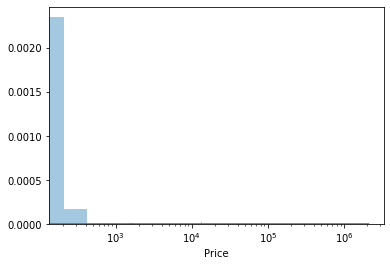

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = sns.distplot(df_join_mismatch.Price, bins=10000)
fig.set_xscale("log")
plt.figure()

In [54]:
len(df_join_mismatch)

3919

Note that in the following notebook, we will restrict any dispatch prices in our price column to what is allowed by the energy market (see README).

### __Checking of price range__

According to the rule set of the Australian energy market, the bidding price range is restricted within a specific limit (see README). Hence, we assume that any price values outside this range are outliers which were not actually reflecting the price of a specific point of time.

We want to restrict all price values to the allowed limit of the Australian energy market. FOr the sake of efficiency, we will do that in a later stage when we have compressed our dataframe further.

In [55]:
print(df.Price.min())
print(df.Price.max())

-26801.01057
2100000.0


Above we can see that there are outlier price values present. We will change that in the next notebook on a compressed file-